# Cartpole optimal control problem

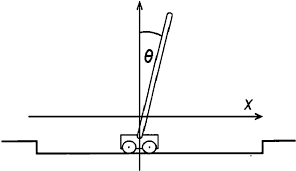

A cartpole is another classical example of control. In this system, an underactuated pole is attached on top of a 1D actuacted cart. The game is to raise the pole to a standing position.

The model is here:
https://en.wikipedia.org/wiki/Inverted_pendulum

We denote by $m_1$ the cart mass, $m_2$ the pole mass ($m=m_1+m_2$), $l$ the pole length, $\theta$ the pole angle w.r.t. the vertical axis, $p$ the cart position, and $g=$9.81 the gravity.

The system acceleration can be rewritten as:

$$\ddot{\theta} = \frac{1}{\mu(\theta)} \big( \frac{\cos \theta}{l} f + \frac{mg}{l} \sin(\theta) - m_2 \cos(\theta) \sin(\theta) \dot{\theta}^2\big),$$

$$\ddot{p} = \frac{1}{\mu(\theta)} \big( f + m_2 \cos(\theta) \sin(\theta) g -m_2 l \sin(\theta) \dot{\theta} \big),$$

$\hspace{12em}$with $$\mu(\theta) = m_1+m_2 \sin(\theta)^2,$$

where $f$ represents the input command (i.e $f=u$) and $m=m_1+m_2$ is the total mass.


## I. Differential Action Model

A Differential Action Model (DAM) describes the action (control/dynamics) in continous-time. In this exercise, we ask you to write the equation of motions for the cartpole.

For more details, see the instructions inside the DifferentialActionModelCartpole class.

In [30]:
import crocoddyl
import pinocchio
import numpy as np
from IPython.display import HTML
from cartpole_utils import animateCartpole


class DifferentialActionModelCartpole(crocoddyl.DifferentialActionModelAbstract):
    def __init__(self):
        crocoddyl.DifferentialActionModelAbstract.__init__(self, crocoddyl.StateVector(4), 1, 6)  # nu = 1; nr = 6
        self.unone = np.zeros(self.nu)

        self.m1 = 1.
        self.m2 = .1
        self.l  = .5
        self.g  = 9.81
        self.costWeights = [1., 1., 0.1, 0.001, 0.001, 1.]  # sin, 1-cos, x, xdot, thdot, f
        
    def calc(self, data, x, u=None):
        if u is None: 
            u = model.unone
        # Getting the state and control variables
        y, th, ydot, thdot = x[0].item(), x[1].item(), x[2].item(), x[3].item()
        f = u[0].item()

        # Shortname for system parameters
        m1, m2, l, g = self.m1, self.m2, self.l, self.g
        s, c = np.sin(th), np.cos(th)

        ###########################################################################
        ############ TODO: Write the dynamics equation of your system #############
        ###########################################################################
        # Hint:
        # You don't need to implement integration rules for your dynamic system.
        # Remember that DAM implemented action models in continuous-time.
        m = m1 + m2
        mu = m1 + m2 * s ** 2
        xddot, thddot = cartpole_dynamics(self, data, x, u)  # Write the cartpole dynamics here
        data.xout = np.matrix([ xddot, thddot ]).T
        
        # Computing the cost residual and value
        data.r = np.matrix(self.costWeights * np.array([ s, 1 - c, y, ydot, thdot, f ])).T
        data.cost = .5 * sum(np.asarray(data.r) ** 2).item()

    def calcDiff(model,data,x,u=None):
        # Advance user might implement the derivatives in cartpole_analytical_derivatives
        cartpole_analytical_derivatives(model, data, x, u)

You can get the solution of the cartpole dynamics by uncommenting the following line:

In [31]:
# %load solutions/cartpole_dyn.py
# Use this function inside DifferentialActionModel.calc by setting:
#      xddot, thddot = cartpole_dynamics(self, data, x, u)


def cartpole_dynamics(model, data, x, u):
    # Getting the state and control variables
    th, thdot = x[1].item(), x[3].item()
    f = u[0].item()

    # Shortname for system parameters
    m1, m2, l, g = model.m1, model.m2, model.l, model.g
    s, c = np.sin(th), np.cos(th)

    # Defining the equation of motions
    m = m1 + m2
    mu = m1 + m2 * s**2
    xddot = (f + m2 * c * s * g - m2 * l * s * thdot) / mu
    thddot = (c * f / l + m * g * s / l - m2 * c * s * thdot**2) / mu

    return [xddot, thddot]


You may want to check your computation. Here is how to create the model and run the calc method.

In [32]:
cartpoleDAM = DifferentialActionModelCartpole()
cartpoleData = cartpoleDAM.createData()
x = cartpoleDAM.state.rand()
u = np.zeros(1)
cartpoleDAM.calc(cartpoleData, x, u)

## II. Write the derivatives with DAMNumDiff

In the previous exercise, we didn't define the derivatives of the cartpole system. In crocoddyl, we can compute them without any additional code thanks to the DifferentialActionModelNumDiff class. This class computes the derivatives through numerical differentiation.

In the following cell, you need to create a cartpole DAM that computes the derivates using NumDiff.

In [33]:
# Creating the carpole DAM using NumDiff for computing the derivatives.
# We specify the withGaussApprox=True to have approximation of the
# Hessian based on the Jacobian of the cost residuals.
cartpoleND = crocoddyl.DifferentialActionModelNumDiff(cartpoleDAM, True)

After creating your cartpole DAM with NumDiff. We would like that you answer the follows:

 - 2 columns of Fx are null. Wich ones? Why?

 - can you double check the values of Fu?


In [34]:
# %load solutions/cartpole_fxfu.py
cartpoleData = cartpoleND.createData()
cartpoleND.calc(cartpoleData, x, u)
cartpoleND.calcDiff(cartpoleData, x, u)
print(cartpoleData.Fx)
print(cartpoleData.Fu)


[[ 0.00000000e+00  9.37784233e-01  0.00000000e+00 -1.33983432e-03]
 [ 0.00000000e+00  2.15004284e+01  0.00000000e+00 -4.45946321e-03]]
[0.99992819 1.99913813]


## III. Integrate the model

After creating DAM for the cartpole system. We need to create an Integrated Action Model (IAM). Remenber that an IAM converts the continuos-time action model into a discrete-time action model. For this exercise we'll use a simpletic Euler integrator.

In [35]:
# %load solutions/cartpole_integration.py
###########################################################################
################## TODO: Create an IAM with from the DAM ##################
###########################################################################
# Hint:
# Use IntegratedActionModelEuler
timeStep = 5e-2
cartpoleIAM = crocoddyl.IntegratedActionModelEuler(cartpoleND, timeStep)


## IV. Write the problem, create the solver

First, you need to describe your shooting problem. For that, you have to indicate the number of knots and their time step. For this exercise we want to use 50 knots with $dt=$5e-2.

Here is how we create the problem.

In [36]:
# Fill the number of knots (T) and the time step (dt)
x0 = np.array([0., 3.14, 0., 0.])
T = 50
problem = crocoddyl.ShootingProblem(x0, [cartpoleIAM] * T, cartpoleIAM)

Problem can not solve, just integrate:

In [37]:
us = [np.zeros(cartpoleIAM.differential.nu)] * T
xs = problem.rollout(us)

In cartpole_utils, we provite a plotCartpole and a animateCartpole methods. Let's display this rollout!

Note that to_jshtml spawns the video control commands.

processing the animation ... 
... processing done


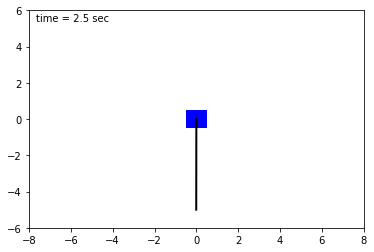

In [38]:
HTML(animateCartpole(xs).to_jshtml())

In [39]:
# %load solutions/cartpole_ddp.py
# #########################################################################
# ################# TODO: Create the DDP solver and run it ###############
# ##########################################################################

# Creating the DDP solver
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving this problem
done = ddp.solve()
print(done)


True


processing the animation ... 
... processing done


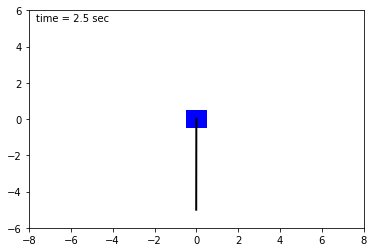

In [40]:
HTML(animateCartpole(ddp.xs.tolist()).to_jshtml())

## Tune the problem, solve it

Give some indication about what should be tried for solving the problem.


 - Without a terminal model, we can see some swings but we cannot stabilize. What should we do?

 - The most important is to reach the standing position. Can we also nullify the velocity?

 - Increasing all the weights is not working. How to slowly increase the penalty?



In [41]:
# %load solutions/cartpole_tuning.py
# ##########################################################################
# ################# TODO: Tune the weights for each cost ###################
# ##########################################################################
terminalCartpole = DifferentialActionModelCartpole()
terminalCartpoleDAM = crocoddyl.DifferentialActionModelNumDiff(terminalCartpole, True)
terminalCartpoleIAM = crocoddyl.IntegratedActionModelEuler(terminalCartpoleDAM)

terminalCartpole.costWeights[0] = 0 # fix me :)
terminalCartpole.costWeights[1] = 0 # fix me :)
terminalCartpole.costWeights[2] = 0 # fix me :)
terminalCartpole.costWeights[3] = 0 # fix me :)
terminalCartpole.costWeights[4] = 0 # fix me :)
terminalCartpole.costWeights[5] = 0 # fix me :)
problem = crocoddyl.ShootingProblem(x0, [cartpoleIAM] * T, terminalCartpoleIAM)

In [42]:
# Creating the DDP solver
ddp = crocoddyl.SolverDDP(problem)
ddp.setCallbacks([crocoddyl.CallbackVerbose()])

# Solving this problem
done = ddp.solve([], [], 300)
print(done)

True


processing the animation ... 
... processing done


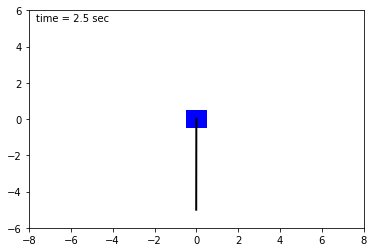

In [43]:
HTML(animateCartpole(ddp.xs.tolist()).to_jshtml())

## Using analytical derivatives

You can get the solution of the analytical derivatives by uncommenting the following line:

In [44]:
# %load solutions/cartpole_analytical_derivatives.py
def cartpole_analytical_derivatives(model, data, x, u=None):
    if u is None:
        u = model.unone

    # Getting the state and control variables
    y, th, ydot, thdot = x[0].item(), x[1].item(), x[2].item(), x[3].item()
    f = u[0].item()

    # Shortname for system parameters
    m1, m2, l, g = model.m1, model.m2, model.l, model.g
    s, c = np.sin(th), np.cos(th)
    m = m1 + m2
    mu = m1 + m2 * s**2
    w = model.costWeights

    # derivative of xddot by x, theta, xdot, thetadot
    # derivative of thddot by x, theta, xdot, thetadot
    data.Fx[:, :] = np.array(
        [[0.0, (m2 * g * c * c - m2 * g * s * s - m2 * l * c * thdot) / mu, 0.0, -m2 * l * s / mu],
         [
             0.0, ((-s * f / l) + (m * g * c / l) - (m2 * c * c * thdot**2) + (m2 * s * s * thdot**2)) / mu, 0.0,
             -2 * m2 * c * s * thdot
         ]])
    # derivative of xddot and thddot by f
    data.Fu[:] = np.array([1 / mu, c / (l * mu)])
    # first derivative of data.cost by x, theta, xdot, thetadot
    data.Lx[:] = np.array([y * w[2]**2, s * ((w[0]**2 - w[1]**2) * c + w[1]**2), ydot * w[3]**2, thdot * w[4]**2])
    # first derivative of data.cost by f
    data.Lu[:] = np.array([f * w[5]**2])
    # second derivative of data.cost by x, theta, xdot, thetadot
    data.Lxx[:] = np.array([w[2]**2, w[0]**2 * (c**2 - s**2) + w[1]**2 * (s**2 - c**2 + c), w[3]**2, w[4]**2])
    # second derivative of data.cost by f
    data.Luu[:] = np.array([w[5]**2])


The analytical derivatives being defined, we do not need to use DAMNumDiff to numerically approximate the derivatives.

In [45]:
timeStep = 5e-2
cartpoleIAM = crocoddyl.IntegratedActionModelEuler(cartpoleDAM, timeStep)

You can now run again all the blocks in "IV. Write the problem, create the solver" since cartpoleIAM has been redefined to directly used the analytical derivatives.